In [1]:
import joblib
import json
from cyvcf2 import VCF, Writer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parents[2] / "src" / "python"))
from paths import validation_path, models_path, training_path
from vcf_helpers import extract_variant_features, normalize_vcf_features_for_prediction, determine_tumor_sample_index, cleanup_dataframe, compare_distributions

In [2]:
model = joblib.load(models_path / "lightgbm_variant_classifier.pkl")
with open(models_path / "model_metadata.json") as f:
    meta = json.load(f)

In [3]:
features = meta["features"]
threshold = meta["threshold"]

In [4]:
# INFO and FORMAT fields to extract
info_fields = [
    "AS_UNIQ_ALT_READ_COUNT", "CONTQ", "DP", "ECNT", "GERMQ",
    "MBQ", "MFRL", "MMQ", "MPOS", "NALOD", "NCount", "NLOD", "OCM", "PON",
    "POPAF", "ROQ", "SEQQ", "STRANDQ", "TLOD", "GOLDEN"
]

format_fields = [
    "AD", "AF", "DP", "F1R2", "F2R1", "GQ", "PL", "SB"
]

split_ref_alt_fields = {"AD", "AF", "F1R2", "F2R1", "SB"}

split_info_ref_alt = {"MBQ", "MFRL", "MMQ"}

# info_fields = [
#     "MBQ", "MMQ", "GOLDEN"
# ]

# format_fields = [
#     "AD", "AF", "F1R2", "F2R1"
# ]

# split_ref_alt_fields = {"AD", "AF", "F1R2", "F2R1"}
# split_info_ref_alt = {"MBQ", "MMQ"}

In [5]:
in_vcf = validation_path / "validation_hg38.vcf"

reader = VCF(in_vcf)
reader.add_info_to_header({
    'ID': 'high_confidence',
    'Description': 'Comma-separated per-ALT high-confidence predictions (T = high confidence)',
    'Type': 'String',
    'Number': '0'
})

0

In [6]:
tumor_index = determine_tumor_sample_index(reader.samples)

Using tumor sample: HG008-T


In [7]:
df = extract_variant_features(reader, info_fields, format_fields, split_info_ref_alt, split_ref_alt_fields, tumor_index)

In [8]:
df = cleanup_dataframe(df)


 Dropped empty or excluded columns:
 - AS_UNIQ_ALT_READ_COUNT
 - CONTQ
 - GERMQ
 - GQ
 - NCount
 - OCM
 - PL
 - PON
 - ROQ
 - SEQQ
 - STRANDQ
 - POPAF


In [9]:
missing = [f for f in features if f not in df.columns]
if missing:
    print("❗ Missing model features:", missing)

In [10]:
df = normalize_vcf_features_for_prediction(df)

In [11]:
bad_dtypes = df[features].dtypes[df[features].dtypes.apply(lambda dt: not np.issubdtype(dt, np.number))]
print("❌ Non-numeric feature columns:")
print(bad_dtypes)

for col in bad_dtypes.index:
    print(f"\nColumn: {col}")
    print(df[col].dropna().unique()[:10])  # Show first few unique non-null values

❌ Non-numeric feature columns:
Series([], dtype: object)


In [12]:
# compare distributions
# train_df = pd.read_csv(training_path / "vcf_feature_vectors.csv")
# compare_distributions(train_df, df)

In [13]:
# Predict
df["probability"] = model.predict_proba(df[features])[:, 1]
df["high_confidence"] = df["probability"] >= threshold

In [14]:
precision = precision_score(df['GOLDEN'].fillna(0).astype(int), df['high_confidence'].astype(int))
recall = recall_score(df['GOLDEN'].fillna(0).astype(int), df['high_confidence'].astype(int))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.7089
Recall: 0.9783


In [15]:
count = (df['probability'] > threshold).sum()
print(f"Number of rows where 'probability' > {threshold}: {count}")

print(df['probability'].describe())

Number of rows where 'probability' > 0.5272908827298157: 3054
count    55820.000000
mean         0.051625
std          0.204447
min          0.000007
25%          0.000022
50%          0.000035
75%          0.000158
max          0.998185
Name: probability, dtype: float64


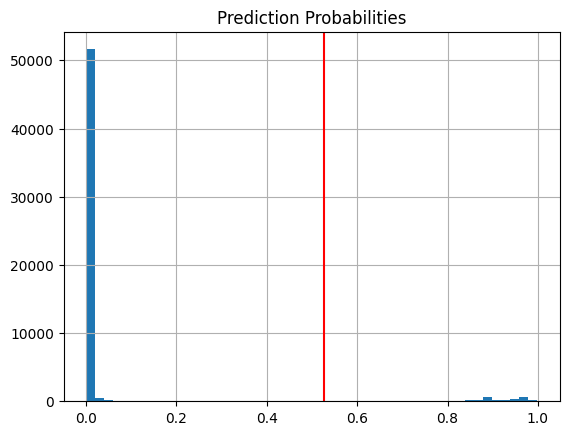

In [16]:
df["probability"].hist(bins=50)
plt.axvline(threshold, color="red")
plt.title("Prediction Probabilities")
plt.show()